# Activating GPU and checking its utilization

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=87eabba388ab00da344ae7c77e1482a2f0fdbaf039501a38631e9be1a39aa888
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.4 GB  | Proc size: 111.2 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Libraries

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import functools
import seaborn as sns
import math, re, os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import gridspec

from matplotlib.image import imread
import shutil

!pip install -q efficientnet
import efficientnet.tfkeras as efn
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,accuracy_score

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalAveragePooling1D,AveragePooling2D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3, VGG16, MobileNetV2
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 51kB 3.6MB/s 


# Flower types used for modeling

In [4]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

# Define image loading and visualization functions

In [5]:
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(512, 512), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 512
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

# Loading trained models

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#model5 = load_model('/content/drive/My Drive/Colab Notebooks/DL Project Models/model5.h5')
model5 = load_model('/content/drive/My Drive/DL Project Models/model5.h5')
model6 = load_model('/content/drive/My Drive/DL Project Models/model6.h5')

In [9]:
print("Summary of DenseNet201 model \n")
model5.summary()
print("\nSummary of EfficientNet B7 model \n")
model6.summary()

Summary of DenseNet201 model 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________

Summary of EfficientNet B7 model 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_

# Flower Classification Prediction

16384/8568 [=========================================================] - 0s 0us/step

 Prediction Result



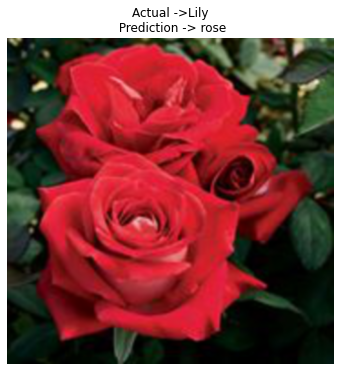

In [12]:
# @title Provide URL of Flower Image  { display-mode: "form" }

url = 'https://www.jacksonandperkins.com/images/m/v2191_1.jpg'  # @param {type:"string"}
name= 'Lily'  # @param {type:"string"}

test_image_size = 512

test_img_size = (test_image_size, test_image_size)


test_images = load_image(url, test_img_size)
test_images = tf.nn.avg_pool(test_images, ksize=[3,3], strides=[1,1], padding='SAME')

pred = (model5.predict(test_images) + model6.predict(test_images))/2
i = np.argmax(pred)

print("\n Prediction Result\n")
show_n([test_images], ['Actual ->'+name+'\n Prediction -> '+CLASSES[i]])






# Flower images urls for Demo


In [ ]:
'''
# Source: https://www.flowerglossary.com/types-of-flowers/

  'pink primrose':'https://i.ebayimg.com/images/g/yQYAAOSwM1FcgsyQ/s-l1600.jpg',
  'petunia':'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Petunia_exserta_by_Scott_Zona_-_004_%281%29.jpg/800px-Petunia_exserta_by_Scott_Zona_-_004_%281%29.jpg',
  'wild rose':'https://www.illinoiswildflowers.info/savanna/photos/wc_rose3.jpg',
  'rose':'https://www.jacksonandperkins.com/images/m/v2191_1.jpg',
  'gazania': 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/WhiteGazania.JPG/659px-WhiteGazania.JPG',
  'lily': 'https://www.flowerglossary.com/wp-content/uploads/2017/09/lily-flower.jpg'
  'pincushion': 'https://www.flowerglossary.com/wp-content/uploads/2017/09/pincushion-flower.jpg'
  'hibicus': 'https://florgeous.com/wp-content/uploads/2019/10/blue-hibiscus-1.jpg,
  'iris' : 'https://www.flowerglossary.com/wp-content/uploads/2017/09/iris-flower.jpg'
  'ageratum':'https://www.flowerglossary.com/wp-content/uploads/2017/09/ageratum.jpg',
  'anemone':'https://www.flowerglossary.com/wp-content/uploads/2017/09/anemone.jpg',
  'aurinia':'https://www.flowerglossary.com/wp-content/uploads/2017/09/basket-of-gold.jpg',
  'buttercup':'https://www.flowerglossary.com/wp-content/uploads/2017/09/buttercup-flower.jpg',
  'boneset' :'https://www.flowerglossary.com/wp-content/uploads/2017/09/boneset.jpg'
'''